In [1]:
import datetime as dt
import matplotlib.pyplot as plt 
import numpy as np 
import numpy.linalg as la 
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from pandas.io.data import DataReader
from scipy.stats import mode 
from scipy.stats.stats import pearsonr
from nearest_correlation import nearcorr
from IPython.display import Image
from cvxpy import Variable, Minimize, quad_form, Problem, sum_entries, norm
%matplotlib inline

Motivation:

-- Correlation and covariance matrices are input parameters for a wide variety of financial models  

-- However, they are prone to estimation error due to outliers, noise, etc. 

-- Poor estimates may have a significant negative impact on subsequent model results

-- We examine one technique for reducing this error, and consider how the raw and filtered S&P 500 covariance matrices that we construct minimally alter a Markowitz-type optimal portfolio using CVXPY

Outline of Talk:

1) Download and wrangle S&P 500 daily price data from Google Finance. 

2) Simulate time series with heavy-tailed daily returns.  Estimate their correlation matrix and examine the distribution of its eigenvalues. 

3) Review a theorem of Marchenko and Pastur related to the functional form of this eigenvalue distribution.

4) Apply these results to the S&P 500 return data and use them to develop an eigenvalue based noise filter.

5) Apply the noise filter, reconstruct the correlation matrix, and find the "nearest" correlation matrix to the filtered matrix. 

6) Examine how the filtered correlation matrix has a minimal affect on the results of a Markowitz type asset allocation optimization problem. 

In [2]:
# Gather Data 
#
# A list of S&P 500 tickers is available at: 
# http://data.okfn.org/data/core/s-and-p-500-companies/r/constituents.csv
#
# One can also build up a potential list of tickers for 
# stocks traded on the NASDAQ, NYSE, and AMEX exchanges from: 
# http://www.nasdaq.com/screening/company-list.aspx

tickerdf = pd.read_csv('SandP500_wiki.csv')    # read in S&P 500 tickers 
tickers = tickerdf['Ticker symbol']       # extract list of tickers from dataframe
verbose_flag = False                      # flag that turns on ticker print statements
start_date = dt.datetime(2010, 1, 1)      # date when to start downloading data
ticker_df_list = []                       # initialize list of dataframes for each ticker                          

for ticker in tickers: 
    try:
        r = DataReader(ticker, "google", start=start_date)   # download price data from yahoo 
        r['Ticker'] = ticker 
        ticker_df_list.append(r)
        if verbose_flag:
            print "Obtained data for ticker %s" % ticker  
    except:
        if verbose_flag:
            print "No data for ticker %s" % ticker  

df = pd.concat(ticker_df_list)        # build single df of all data
cell= df[['Ticker','Close']]          # extract ticker and close price information 
cell.reset_index().sort(['Ticker', 'Date'], ascending=[1,0]).set_index('Ticker')
cell.to_pickle('google_close_price.pkl')         # pickle data

We first simulate time series whose differences are drawn from a heavy tailed distribution. Specifically, we: 

1) Take 2000 draws from a Student's t distribution with degree of freedom parameter 5 for 500 paths 

2) Compute the cumulative sum of each time series and plot the results in the first figure below

3) Plot the distribution of differences of one of the time series in the second plot below

4) Estimate the correlation matrix between the different series, compute its eigenvalues, and plot their histogram in the third plot

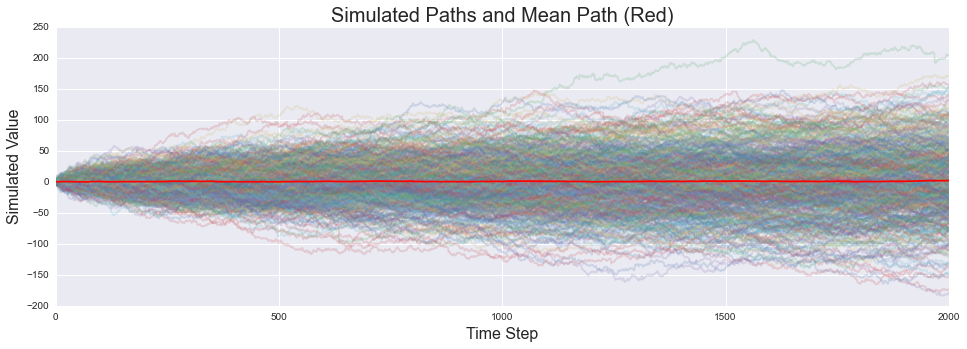

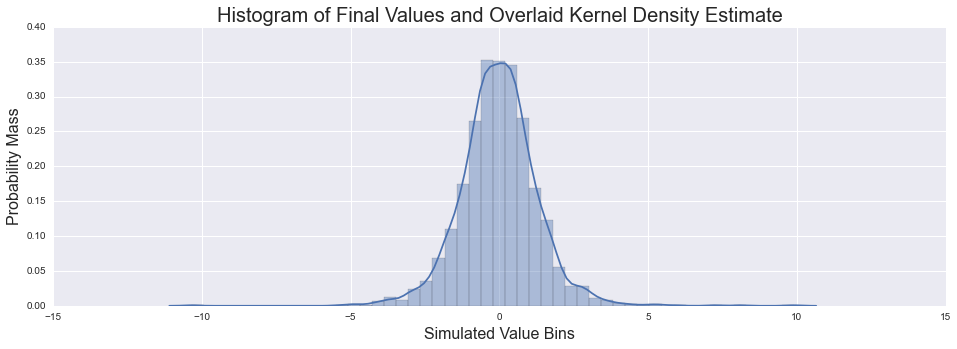

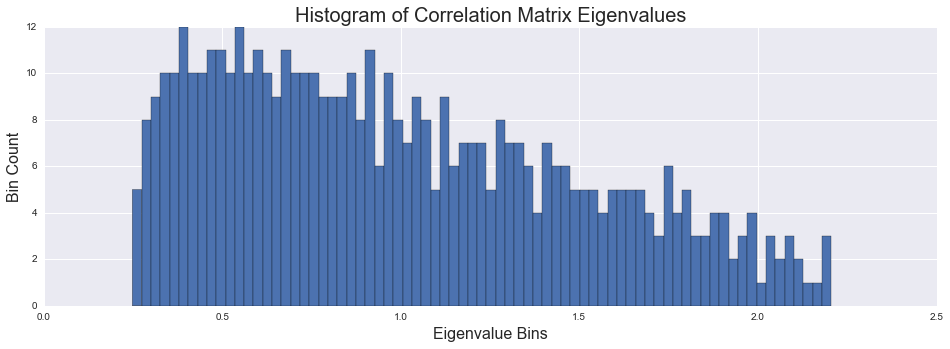

In [3]:
deg_freedom = 5  # Student's t distribution degree of freedom parameter 
num_srs = 500    # number of time series to generate  
num_pts = 2000   # number of points per time series 
rpaths = np.random.standard_t(deg_freedom,size=(num_pts,num_srs))  # generate paths
evalplot = la.eig(pd.DataFrame(rpaths).corr())[0]                  # compute eigenvalues

plt.figure(figsize=(16,5))                                           
plt.plot(rpaths.cumsum(axis=0),alpha=0.2)
plt.xlabel("Time Step",fontsize=16)
plt.ylabel("Simulated Value",fontsize=16)
plt.title("Simulated Paths and Mean Path (Red)", fontsize=20)
sns.tsplot(rpaths.cumsum(axis=0).T, color = "r")
plt.figure(figsize=(16,5))
sns.distplot(rpaths.T[1],bins=50);
plt.xlabel("Simulated Value Bins",fontsize=16)
plt.ylabel("Probability Mass",fontsize=16)
plt.title("Histogram of Final Values and Overlaid Kernel Density Estimate", fontsize=20)
plt.figure(figsize=(16,5))
plt.hist(evalplot,bins=75);
plt.xlabel("Eigenvalue Bins",fontsize=16)
plt.ylabel("Bin Count",fontsize=16)
plt.title("Histogram of Correlation Matrix Eigenvalues", fontsize=20)

Note that the eigenvalue distribution has an interesting shape.  We paraphrase a theorem of Marchenko and Pastur that describes the functional form of this shape:


Let $X$ be a random $n\times r$ matrix whose entries are i.i.d. and have finite constant variance $\sigma^2$.  Then the eigenvalues of the correlation matrix corresponding to $X$ are distributed according to
$$
f(\lambda)=\frac{q}{2\pi\lambda}\sqrt{(\lambda_+ - \lambda)(\lambda-\lambda_-)}
\:\:\mathrm{for} \:\: \lambda\in[\lambda_-,\lambda_+] \:\: 
\mathrm{where\:\:} \lambda_{\pm} = 1+\frac{1}{q}\pm 2\sqrt{\frac{1}{q}} \:\: \mathrm{and} \:\: q = \frac{n}{r}
$$

We plot this function overlaid on the eigenvalue histogram below. 

In our application, the columns of $X$ will correspond to normalized stock daily return time series.  

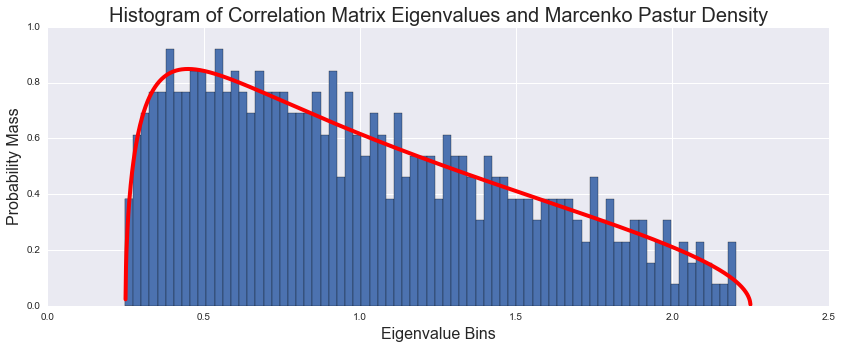

In [4]:
def eigden(lam,n,r):
    '''
    Definition of the Marchenko Pastur density 
    '''
    q = float(n)/r
    lplus = 1+1/q+2*np.sqrt(1/q)
    lminus = 1+1/q-2*np.sqrt(1/q)
    return q/(2*np.pi*lam)*np.sqrt((lplus-lam)*(lam-lminus))

lamvls = np.linspace(0.001,3,2000) 
plt.figure(figsize=(14,5))
plt.hist(evalplot,bins=75,normed=True)
plt.plot(lamvls,[eigden(lam,num_pts,num_srs) for lam in lamvls], color="r", linewidth=4)
plt.xlabel("Eigenvalue Bins",fontsize=16)
plt.ylabel("Probability Mass",fontsize=16)
plt.title("Histogram of Correlation Matrix Eigenvalues and Marcenko Pastur Density", fontsize=20)
plt.show()

We now construct a noise filtering algorithm based on one developed by Bouchaud and Potters that utilizes the upper bound of this function and apply it to the S&P 500 data.  Specifically, we:

-- Specify a start and end date for the timeseries that we want to consider and compute the mode of the lengths of these series. 

-- We keep series that have lengths equal to this mode, compute their daily returns, normalize the variance of each time series to one, and store the result in a dataframe.
 

In [5]:
def lamplus(n,r): 
    '''
    Upper eigenvalue limit of the Marchenko Pastur density 
    '''
    q = float(n)/float(r)
    return (1+1/q+2*np.sqrt(1/q))

# Read in closing price data if it is not already a local variable
if 'cell' not in locals():
    df = pd.read_pickle('google_close_price.pkl')
else: 
    df = cell 
    
dte1 = '2010-07-01'
dte2 = '2015-10-01'
tickers = sorted(list(set(df['Ticker'].values)))                   # sorted list of unique tickers  
tkrlens = [len(df[df.Ticker==tkr][dte1:dte2]) for tkr in tickers]  # find lengths of times series for each ticker 
tkrmode = mode(tkrlens)[0][0]                                      # find mode of time series lengths 

# idenfity tickers whose lenghts equal the mode and call these good tickers
good_tickers = [tickers[i] for i,tkr in enumerate(tkrlens) if tkrlens[i]==tkrmode]  

rtndf = pd.DataFrame()  # initialize a return dataframe
non_norm_rtndf = pd.DataFrame()
std_lst = [] # list of standard deviations of return time series

# Normalize all time series to have mean zero and variance one and compute their returns 
for tkr in good_tickers: 
    tmpdf = df[df.Ticker==tkr]['Close'][dte1:dte2]
    tmprtndf = ((tmpdf-tmpdf.shift(1))/tmpdf).dropna()
    std_lst.append(np.std(tmprtndf))
    rsdf = (tmprtndf-tmprtndf.mean())/tmprtndf.std()
    rtndf = pd.concat([rtndf, rsdf],axis=1)
    non_norm_rtndf = pd.concat([non_norm_rtndf, tmprtndf],axis=1)

We now drop Nans, and compute the correlation matrix between the return time series.  Specifically if $X_i$, $Y_i$ for $i=1,\ldots,n$ are two time series corresponding to normalized daily returns of two stocks $X$ and $Y$ that we are considering, the entry of the correlation matrix corresponding to these two time series is given by

$$
\rho_{XY} = \frac{\mathrm{Cov}(X,Y)}{\sqrt{\mathrm{Var}{X}\mathrm{Var}{Y}}},\quad\mathrm{where}\quad \mathrm{Cov}(X,Y) = \frac{1}{n-1}\sum_{i=1}^n(X_i-\bar{X})(Y_i-\bar{Y}),
$$
$$
\mathrm{Var}(X) = \mathrm{Cov}(X,X), \quad \bar{X} = \frac{1}{n}\sum_{i=1}^n X_i. 
$$

Denote the entire correlation matrix by $\rho$ and its corresponding eigenvalue, eigenvector pairs by $(\lambda_i,e_i)$ for $i=1,\ldots, n$ and $\lambda_1\geq \lambda_2\geq \cdots \geq \lambda_n$. 

Note that we can write 
$$ 
\rho = \Sigma \Lambda \Sigma^{-1},\quad \mathrm{where} \quad \Sigma = (e_1,\ldots, e_n),\quad \mathrm{and} \quad \Lambda = \mathrm{diag}(\lambda_1,\ldots,\lambda_n), 
$$

where we replace $\lambda_i$ with $|\lambda_i|$ in the computation below since we find many of the eigenvalues have a small imaginary part due to numerical error. 


In [6]:
rtndf = rtndf.dropna()
rtndf.columns = good_tickers
non_norm_rtndf = non_norm_rtndf.dropna()
non_norm_rtndf.columns = good_tickers
t,m = rtndf.shape
cmat = rtndf.corr()                   # compute correlation matrix 
evls, evcs = la.eig(cmat)             # compute eigenvalue/vector decomposition of matrix 
evallst = map(abs,evls)               # take abs of evals (very small imag parts)             

We now perform the filtering procedure by first computing the upper noise eigenvalue $\lambda_+$ and then dividing the $\lambda_i$ into two sets $[\lambda_n,\ldots,\lambda_{k}]$ and $[\lambda_{k-1},\ldots,\lambda_1]$ where here $k\leq n$ and $\lambda_{k-1}\leq\lambda_+\leq\lambda_k$.  Filtering consists of replacing all eigenvalues in the first set with the average noise eigenvalue $\tilde{\lambda} = \frac{1}{k-1}\sum_{i=1}^{k-1}\lambda_i$, and defining the altered eigenvalue matrix 

$$
\tilde{\Lambda} = \mathrm{diag}(\tilde{\lambda},\ldots,\tilde{\lambda},\lambda_k,\ldots,\lambda_n)
$$

so that $\mathrm{tr}(\Lambda)=\sum_{i=1}^n \lambda_i= (k-1)\tilde{\lambda}+\sum_{i=k}^n\lambda_i =\mathrm{tr}(\tilde{\Lambda})=n$, i.e. we do not alter the trace 

In [7]:
filtvals = [val for val in evallst if val < lamplus(t,m)]     # filter eigenvalues 
sevlist = [np.mean(filtvals)]*len(filtvals)                 
feval = evallst[:(len(evallst)-len(sevlist))] + sevlist       # build list of new eigenvalues

The final portion of the filtering problem consists of reconstructing the correlation matrix from the filtered eigenvalues, in particular, we compute

$$
\tilde{\rho} = \Sigma\tilde{\Lambda}\Sigma^{-1}
$$

Next we symmetrize $\tilde{\rho}$

$$ 
\tilde{\rho}_1 = \frac{1}{2}(\tilde{\rho}+\tilde{\rho}^T)
$$

We finally note that $\tilde{\rho}_1$ is not guarenteed to be a true correlation matrix, specifically, the diagonal entries are not always $1$'s.   Thus we search over the space of positive definite, symmetric matrices with ones on the main diagonal to find the one that most closely matches the candidate matrix in the Frobenius norm sense. We consider the following opimization problem: 

$$
\hat{\rho} = \min_{x\in S} ||x - \tilde{\rho}_1 ||^2_F,\quad\mathrm{where}\quad S = [x\in\mathrm{GL}(N),\:x = x^T,\:  x_{ii}=1,\: \lambda_i(x) > 0 ],
$$
$$
\quad\mathrm{and}\quad || x - y||_F^2 = \sum_{i,j=1}^n (x_{ij}-y_{ij})^2
$$

We apply an open source optimizer (due to Mike Croucher available at: https://github.com/mikecroucher/nearest_correlation) that is tailored to this problem in the nearcorr function below 

In [8]:
rcmat = abs(np.dot(np.dot(evcs,np.diag(feval)),la.inv(evcs))) # reconstruct candidate correlation matrix 
rcmat = (rcmat + rcmat.T)/2                                   # symmetrize the candidate matrix 
ncorr = nearcorr(rcmat, max_iterations=1000)                  # find nearest correlation matrix 

We plot the top ten eigenvalues of our S&P 500 correlation matrix as well as a histogram of the smaller eigenvalues overlaid with the Marchenko Pastur density below.

[ 186.48218152   14.73556411    9.51981203    6.72486409    5.37382408
    4.50626454    3.8396991     3.16109878    3.03215959    2.65077285]


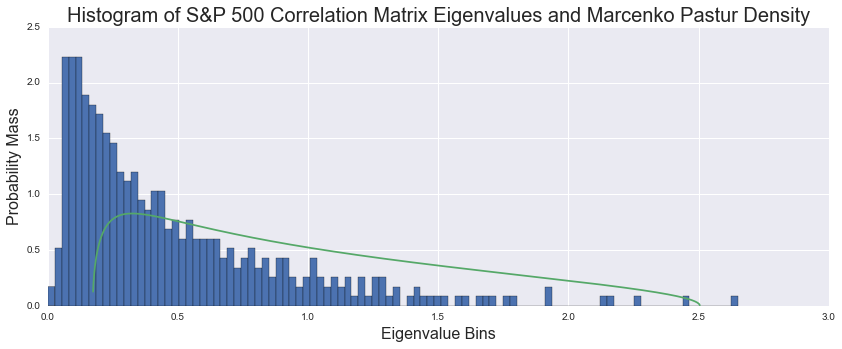

In [9]:
print evls[0:10]
plt.figure(figsize=(14,5))
plt.hist([val for val in evls if val < 3],bins=100,normed=True);
plt.plot(lamvls,[eigden(lam,len(rtndf),len(rtndf.columns)) for lam in lamvls]);
plt.xlabel("Eigenvalue Bins",fontsize=16)
plt.ylabel("Probability Mass",fontsize=16)
plt.title("Histogram of S&P 500 Correlation Matrix Eigenvalues and Marcenko Pastur Density", fontsize=20)

We now display a matrix heatmap plot of the differences between the original and filtered correlation matricies as well as a histogram of all differences below

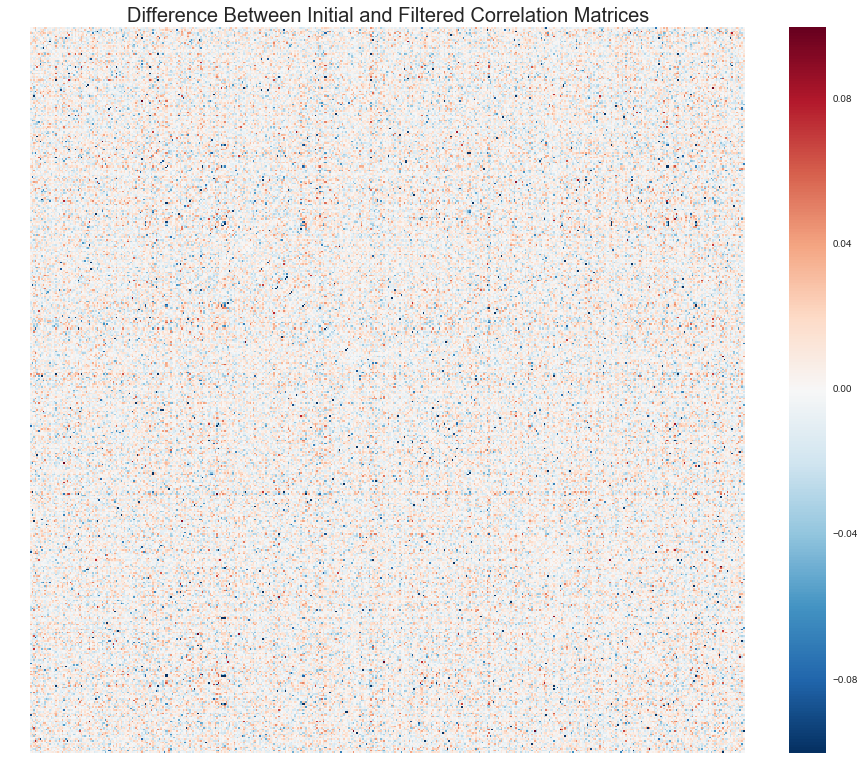

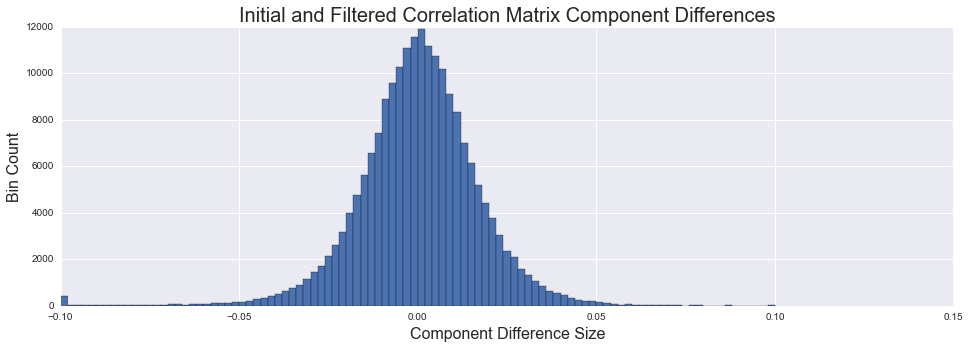

In [11]:
plt.figure(figsize=(16,13))
corrdiff = np.array(ncorr - cmat)
corrdiff = np.array([map(lambda x: min(x,0.1), row) for row in corrdiff])
corrdiff = np.array([map(lambda x: max(x,-0.1), row) for row in corrdiff])
sns.heatmap(corrdiff)
plt.axis('off')
plt.title('Difference Between Initial and Filtered Correlation Matrices', fontsize=20)

plt.figure(figsize=(16,5))
plt.hist(corrdiff.flatten(),bins = 100)
plt.xlabel("Component Difference Size",fontsize=16)
plt.ylabel("Bin Count",fontsize=16)
plt.title("Initial and Filtered Correlation Matrix Component Differences", fontsize=20)
plt.show()

We now reconstruct the covariance matricies associated with both the raw and filtered correlation matricies as well as the vector of expected daily returns of each stock   

In [12]:
ocov = np.array([[std_lst[i]*std_lst[j]*cmat.as_matrix()[i][j] for i in xrange(0,len(std_lst))] for j in xrange(0,len(std_lst))])
ncov = np.array([[std_lst[i]*std_lst[j]*ncorr[i][j] for i in xrange(0,len(std_lst))] for j in xrange(0,len(std_lst))])
dly_rtn = np.array(non_norm_rtndf.cumsum().tail(1)/len(non_norm_rtndf))[0]

We use CVXPY (http://www.cvxpy.org/en/latest/) created by Steven Diamond a new simple interface to multiple open source convex optimizers including CVXOPT, ECOS, SCS as well as proprietary optimizers in order to solve the following Markowitz type asset allocation problem: 

Given an estimated covariance matrix $\hat{\Sigma}$ of daily returns and an expected daily return $\hat{\mu}$, we seek to find the asset weights $w=[w_1,\ldots,w_n]$ by solving the following optimization problem:

$$
\hat{w} = \underset{w}{\mathrm{argmin}}\:\: w^T\hat{\Sigma}w - \lambda\hat{\mu}^T w + \gamma|w|_1, \quad |w|_1 = \sum_{i=1}^n |w_i|,
$$

subject to the constraints that $\sum w_i = 1$. We note that the regularization term was choosen to prefer long/short portfolios that consist of only a small number stocks (which is more practical from a trading perspective).  This also enhances the stability of the optimization procedure.

Below, we solve this problem for varying $\lambda$ values while fixing $\mu=0.003$. 



In [13]:
lam = np.linspace(-2,2,200)

def mv_opt_port(cov,dly_rtn,div_param,lam_lst):
    n = len(cov)
    vlst = []
    rtnlst = []
    
    for v in lam_lst:
        x = Variable(n)
        objective = Minimize(quad_form(x,cov)-v*dly_rtn.T*x + div_param*norm(x,1))
        constraints = [sum_entries(x)==1]
        p = Problem(objective, constraints)
        L = p.solve()
        
        wopt = np.array(x.value).flatten()
        vlst.append(wopt.T.dot(ocov).dot(wopt))
        rtnlst.append(wopt.dot(dly_rtn))
    
    return (wopt,vlst, rtnlst)


wopt, vtmp, rtntmp = mv_opt_port(ocov, dly_rtn, 0.003, lam)    
wopt1, vtmp1, rtntmp1 = mv_opt_port(ncov, dly_rtn, 0.003, lam)    


We now plot the efficient frontier of both models; this is constructed by varying the $\lambda$ parameter and for each value solving the above optimization problem and saving the expected return and volatility of the associated optimal portfolio.

We plot both efficient frontiers in blue and green below as well as the volatility and expected returns for each of individual stocks we considered in a scatter plot.

Note that the results do not significantly differ.

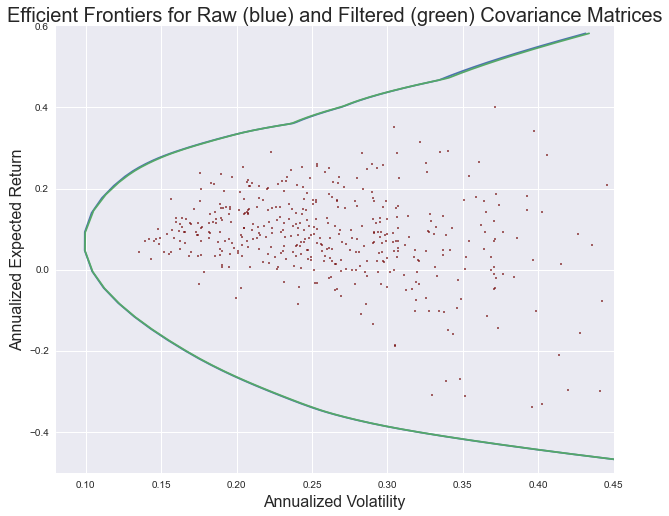

In [35]:
plt.figure(figsize=(10,8))

xplt = 252*np.array(vtmp)
yplt = 252*np.array(rtntmp)
x1plt = 252*np.array(vtmp1)
y1plt = 252*np.array(rtntmp1)

pltvec=pd.concat([non_norm_rtndf.std(),non_norm_rtndf.mean()],axis=1).as_matrix()
pltarr = pd.concat([non_norm_rtndf.std(),non_norm_rtndf.mean()],axis=1).as_matrix()
pltarr = np.array([val for val in pltarr if val[0]<0.1])
plt.scatter(np.sqrt(252)*pltarr.T[0],252*pltarr.T[1],s=2,c='r')
plt.plot(np.sqrt(xplt),yplt, np.sqrt(x1plt),y1plt)
plt.xlim(0.08,0.45)
plt.ylim(-0.5,0.6) 
plt.xlabel("Annualized Volatility",fontsize=16)
plt.ylabel("Annualized Expected Return",fontsize=16)
plt.title("Efficient Frontiers for Raw (blue) and Filtered (green) Covariance Matrices", fontsize=20)
plt.show()

References:

Email: steve98654-at-gmail-dot-com

CVXPY -- http://www.cvxpy.org/en/latest/

Talk on GitHub: https://github.com/steve98654/PyTalk/  (file corr_filt.ipynb)

Bouchaud and Potters: Financial Applications of Random Matrix Theory (a short review) http://arxiv.org/pdf/0910.1205.pdf

Marchenko,V. A., Pastur, L. A. (1967) "Distribution of eigenvalues for some sets of random matrices", Mat. Sb. (N.S.), 72(114):4, 507–536
